# Solution analytique en tube

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import copy
import os, sys
from string import Template
import time
from IPython.display import display
import math

from trustutils import run 
from trustutils import visit
from trustutils.jupyter import plot

run.TRUST_parameters()


# See Marfaing, O., Guingo, M., Laviéville, J., Bois, G., Méchitoua, N., Mérigoux, N., & Mimouni, S. (2016). An analytical relation for the void fraction distribution in a fully developed bubbly flow in a vertical pipe. Chemical Engineering Science, 152, 579-585.

ModuleNotFoundError: No module named 'trustutils'

In [5]:
sondes = { }

n_seg_sonde = 40
r_tube = 0.019

tab_name_sondes = ["k",
                   "omega",
                   "vitesse_liquide_eau",
                   "vitesse_gaz_air",
                   "alpha_gaz_air",
                   "pression",
                   "dp",
                   "lift",
                   "disp",
                   "vorticite"
				   ]


x_0 = r_tube/(2*n_seg_sonde)*np.cos(np.pi*.5/360)
y_0 = r_tube/(2*n_seg_sonde)*np.sin(np.pi*.5/360)

x_wall = r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)*np.cos(np.pi*.5/360)
y_wall = r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)*np.sin(np.pi*.5/360)

z_sonde = 1.49

str_sonde = " "
for name_sonde in tab_name_sondes:
    str_sonde += f" {name_sonde} {name_sonde} periode 1.e-2 segment {n_seg_sonde} {x_0} {y_0} {z_sonde} {x_wall} {y_wall} {z_sonde}  \n"

sondes["PolyMAC"] = str_sonde

str_sonde = " "
for name_sonde in tab_name_sondes:
    str_sonde += f" {name_sonde} {name_sonde} periode 1.e-2 segment {n_seg_sonde} {r_tube/(2*n_seg_sonde)} {z_sonde} {r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)} {z_sonde}  \n"

sondes["VDF"] = str_sonde


In [13]:
#Create the calculation cases

force_recalculation = True 
number_of_partitions = 4

# Refinement
med_file   = {  "VDF" : "",  "PolyMAC" : "1_tube_analytique.med" }
name_mesh  = { "PolyMAC" : "Lire_med family_names_from_group_names dom mesh 1_tube_analytique.med " ,
                "VDF" : "Mailler dom { Pave tube  { Origine 0. 0. Nombre_de_Noeuds 41 201 Longueurs  0.019 1.5 }  { bord symetrie    X = 0   0 <= Y <= 1.5  bord top   Y = 1.5   0 <= X <= 0.019  bord bottom    Y = 0   0 <= X <= 0.019 bord wall   X = 0.019 0 <= Y <= 1.5 } } " }
schema = { "VDF" : " vdf  dis option_vdf { all_options } ", "PolyMAC" : " PolyMAC_P0  dis option_PolyMAC_P0 { traitement_axi } " }
dimension = { "VDF" : 2,  "PolyMAC" : 3}
bidim_axi = { "VDF" : " bidim_axi ",  "PolyMAC" : " "}
nrad = { "VDF" : 40,  "PolyMAC" : 40}
solveur = { "ICE" : "", "SETS" : " 	facsec_diffusion_for_sets 100 " }
#solveur = { "ICE" : "" }
paroi = { "VDF" : " symetrie ",  "PolyMAC" : " paroi "}
paroi_adiabatique = { "VDF" : " symetrie ",  "PolyMAC" : " paroi_adiabatique "}

# Numerical parameters
facsec  = 1
tmax    = 8
nb_pas_dt_max = '100000'
seuil_statio  = '1.e-3'

#Physical quantities
air_properties =   "     gaz_air Fluide_Incompressible { mu champ_uniforme 1 1.e-5 rho champ_uniforme 1  1.   lambda Champ_Uniforme  1 0.023 Cp Champ_Uniforme 1 1006   beta_th Champ_Uniforme 1 0 } "
water_properties = " liquide_eau Fluide_Incompressible { mu champ_uniforme 1 1.e-3 rho champ_uniforme 1  1.e3 lambda Champ_Uniforme  1 0.604 Cp Champ_Uniforme 1 75.366 beta_th Champ_Uniforme 1 0 } "
interface =        "interface_eau_air interface_sigma_constant  { tension_superficielle 0.0728 }"
u_0 = 20000*1.e-6/0.038 #Re 20000
alpha_cible = 0.02

#Turbulent quantities
D_h = 0.038
CI_om = u_0/D_h
CI_k  = 0.01*u_0**2
        
#Two-phase quantities
Cd = .1
frottement_interfacial = " bulles_constant { coeff_derive " + f"{Cd}" + " } " 
Cl = 0.03
portance_interfaciale = " constante { Cl " + f"{Cl}" + " } " 
D_td_star = 0.003
dispersion_bulles = " constante {   D_td_star " + f"{D_td_star}" +" } " 
db = 0.0025
beta_portance = "1"
beta_disp     = "1"
Cw1 = -.1
Cw2 = .147
u_r = np.sqrt(4.*db/(3*Cd)*9.81)
alpha_entree = alpha_cible *(u_0+u_r)/u_0


def GenerateInputFile(name,substitutions_dict):
    with open(f"build/jdd.data", "r") as file: 
        filedata = Template(file.read())
    result = filedata.substitute(substitutions_dict)
    with open(f"build/{name}.data", "w") as file:
        file.write(result)

if force_recalculation or not os.path.exists('build'):
    print('Recalculation running..')
    run.reset()
    run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

    for s in schema.keys() :
        for solv in solveur.keys() :
            name = f"{s}_{solv}"

            os.system(f'mkdir build/{name}')

            if (med_file[s]!=""):
                os.system(f'cp src/{med_file[s]} build/{name}/{med_file[s]}')
                    
            substitutions_dict = {"dimension" : dimension[s],
                                    "bidim_axi" : bidim_axi[s],
                                    "name_mesh" : f'{name_mesh[s]}' ,
                                    "schema" : schema[s],

                                    "tmax": str(tmax),                                  
                                    "facsec" : str(facsec) ,
                                    "nb_pas_dt_max" : nb_pas_dt_max ,
                                    "seuil_statio" : seuil_statio ,
                                    "solveur" : solv ,
                                    "facsec_diffusion_for_sets" : solveur[solv] ,
                                                
                                    "carrying_phase" : water_properties ,
                                    "dispersed_phase" : air_properties ,
                                    "interface" : interface,
                                                
                                    "diametre_bulles" : str(db),
                                    "u_0"  : f"{2*dimension[s]} {''.join([ ' 0 ' for i in range(2*(dimension[s]-1))])} {u_0} {u_0} " ,
                                    "grav"   : f"{2*dimension[s]} {''.join([ ' 0 ' for i in range(2*(dimension[s]-1))])} -9.81 -9.81 " ,
                                    "alpha_l0" : str(1-alpha_entree) ,
                                    "alpha_v0" : str(alpha_entree) ,
                                    "frottement_interfacial" : frottement_interfacial,
                                    "portance_interfaciale" : portance_interfaciale,
                                    "dispersion_bulles" : dispersion_bulles,
                                    "beta_portance" : beta_portance,
                                    "beta_disp" : beta_disp,
                                                
                                    "CI_diss": f"{CI_om}" ,
                                    "CI_k": f"{CI_k}" ,
                                    "paroi_adiabatique" : paroi_adiabatique[s],
                                    "paroi" : paroi[s],

                                    "sondes" : sondes[s],
                                                
                                }

            GenerateInputFile(f"jdd_{name}",substitutions_dict)
            if number_of_partitions == 1:
                run.addCase(".", f"jdd_{name}.data")
            else:
                os.system(f'mv build/jdd_{name}.data build/{name}')
                os.system(f'cd build/{name};  make_PAR.data jdd_{name} {number_of_partitions}; cd ../..')                            
                run.addCase(f"./{name}", f"PAR_jdd_{name}.data",nbProcs=number_of_partitions)
        
    run.runCases()
    display(run.tablePerf())

else:
    print('No recalculation, reusing old results!')

Recalculation running..
Usage: make_PAR.data datafile [NB_CPUs]
Wait for partitionning...End.
To run the parallel calculation on 8 CPUs:
trust PAR_jdd_VDF_raf_1 8
Usage: make_PAR.data datafile [NB_CPUs]
Wait for partitionning...End.
To run the parallel calculation on 8 CPUs:
trust PAR_jdd_PolyMAC_raf_1 8
Running ...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Case 'VDF_raf_1/PAR_jdd_VDF_raf_1.data' FAILED !! Here are the last 20 lines of the log file:
(If you don't see anything suspicious, also check pre/post_run scripts!!)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Reading of term frottement_interfacial
and typing: frottement_interfacial_VDF_Face
Reading of term portance_interfaciale
and typing: portance_interfaciale_VDF_Face
Champs_compris::ajoute_champ vorticite
Champs_compris::ajoute_champ gradient_vitesse
Reading of term Dispersion_bulles
and typing: Dispersion_bulles_VDF_Face
Reading of term C

,host,system,Total CPU Time,CPU time/step,number of cells
VDF_raf_1/PAR_jdd_VDF_raf_1,is245493,Linux,1.000000e+09,?,8000
PolyMAC_raf_1/PAR_jdd_PolyMAC_raf_1,is245493,Linux,8.279950e-01,0.545526,8000
Total,,,1.000000e+09,,


In [4]:
def loadText(data, index_column=0, nb_column=-1, transpose=True, dtype="float", skiprows=0):
        
    if nb_column == -1:
        nb = None
    else:
        nb = index_column + nb_column

    try:
        if transpose:
            matrix = np.loadtxt(f'build/{data}', dtype=dtype, skiprows=skiprows).T[index_column:nb]
        else:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)[index_column:nb]
    except:
        matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)        
        
    return matrix


In [6]:
## Loading simulation results

############# results : sim[config][debit air][raf][position]
#############         columns : ['y/h'] ['vxl'] ['vyl'] ['vxg'] ['vyg'] ['k'] ['alp'] ['DB']
#############                   ["diff"] ["conv"] ["press"] ["grav"] ["drag"] ["lift"] ["disp"] ["lub"]
#############               nb : end column name with lx for forces
############# sim name : tab_name [config][debit air][raf]
############# sim label: tab_label[config][debit air][raf]
############# convergence :  dt_ev[config][debit air][raf]
#############         columns : ['time']['dt']['facsec']['residu']['dt_stab']['vitl']['vitg']['alphal']['alphag']['Tl']['Tg']['diss']['k'] 

sim      =  {  }
dt_ev    = {  }

for s in schema.keys() :
    for solv in solveur.keys() :
        name = f"{s}_{solv}"

        dt_ev[name] = pd.read_csv(f"build/{name}/PAR_jdd_{name}.dt_ev", "\t")
        dt_ev[name] = dt_ev[name].iloc[:,:13]
        dt_ev[name].columns = ['time', 'dt', 'facsec', 'residu', 'dt_stab', 'vitl', 'vitg', 'alphal', 'alphag', 'Tl', 'Tg', 'diss', 'k']               

        sim[name] = pd.DataFrame()
        sim[name]['r+']= np.linspace(1./(2*n_seg_sonde),1-1./(2*n_seg_sonde), 40)
        sim[name]['vxl']=np.array(loadText(f"{name}/PAR_jdd_{name}_VITESSE_LIQUIDE_EAU.son"))[1::dimension[s],-1]
        sim[name]['vzl']=np.array(loadText(f"{name}/PAR_jdd_{name}_VITESSE_LIQUIDE_EAU.son"))[dimension[s]::dimension[s],-1]
        sim[name]['vxg']=np.array(loadText(f"{name}/PAR_jdd_{name}_VITESSE_GAZ_AIR.son"))[1::dimension[s],-1]
        sim[name]['vzg']=np.array(loadText(f"{name}/PAR_jdd_{name}_VITESSE_GAZ_AIR.son"))[dimension[s]::dimension[s],-1]
        sim[name]['k']  =np.array(loadText(f"{name}/PAR_jdd_{name}_K.son"))[1::,-1]
        sim[name]['alp']=np.array(loadText(f"{name}/PAR_jdd_{name}_ALPHA_GAZ_AIR.son"))[1::,-1]
        sim[name]['p']  =np.array(loadText(f"{name}/PAR_jdd_{name}_PRESSION.son"))[1::,-1]
        sim[name]['dp'] =np.array(loadText(f"{name}/PAR_jdd_{name}_DP.son"))[1::,-1]


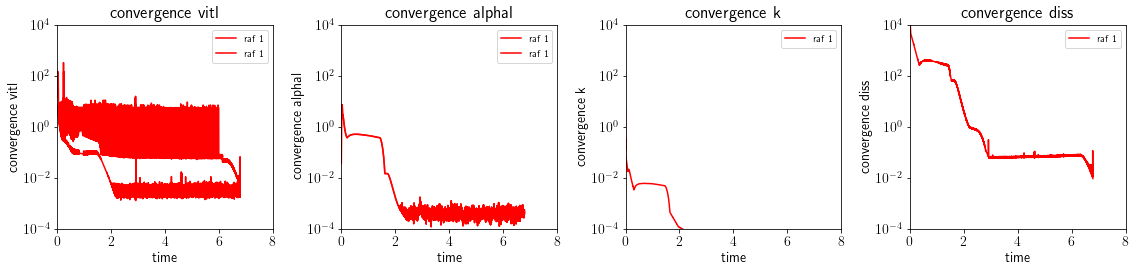

In [7]:
## plotting convergence

matplotlib.rcParams.update({'font.size': 14})

color_conf = { "VDF_ICE" : "red", "PolyMAC_ICE" : "magenta", "VDF_SETS" : "orange", "PolyMAC_SETS" : "purple"  }

fig = plt.figure(figsize = (16, 4))

name_phys = [ ["vitl", "vitg"], ["alphal", "alphag"],  ["k"], ["diss"]]

axs = fig.subplots(1, len(name_phys) )#, sharex=True, sharey=True)

for l in range(len(name_phys)): #phys
    for r in dt_ev.keys() :
        for lp in range(len(name_phys[l])) : #physique de la phase si multiphase
            axs[l].plot(dt_ev[r]["time"][::], dt_ev[r][name_phys[l][lp]][::], "-", label = r.replace("_", " "), color = color_conf[r])

        axs[l].set_xlim(0,tmax)
        axs[l].set_ylim(float(seuil_statio)/100, 1e4)
        axs[l].set_yscale("log")
        axs[l].set_title("convergence "+name_phys[l][0] )
        axs[l].set_xlabel('time')
        axs[l].set_ylabel("convergence " + name_phys[l][0])
        axs[l].legend(prop={'size': 10})

plt.tight_layout()
plt.savefig("convergence.pdf")

In [8]:
# Calculer les résultats analytiques

B = 1.5e15*(u_0+u_r)/u_0
l_sim = len(sim["PolyMAC_ICE"]["r+"] )

rp  = sim["PolyMAC_ICE"]["r+"] 
r   = rp * D_h/2.
R   = np.zeros(l_sim) + D_h/2.
y   = R-r
y_st= 2*y/db
r_st= 2*r/db
R_st= 2*R/db
Ur  = np.zeros(l_sim) + np.sqrt(4.*db/(3*Cd)*9.81) #Ug-Ul
u_to= 0.1987*u_0*(u_0*D_h/(1.e-6))**(-1./8) #For liquid phase
y_p = u_to * y / (1.e-6)
Vl  = np.array(sim["PolyMAC_ICE"]["vzl"])   
Vl_st=Vl/Ur
P   = np.array(sim["PolyMAC_ICE"]["p"])
P_st= P/(1000*Ur**2)
P_stR=sim["PolyMAC_ICE"]["p"][l_sim-1]/(1000*Ur**2)
Y_st= np.minimum(-Cw2/Cw1 + np.zeros(l_sim), y_st)

alp = B * np.exp( (np.log(Y_st)*Cw2+Cw1*Y_st-Cl*Vl_st+(P_st-P_stR))/D_td_star)


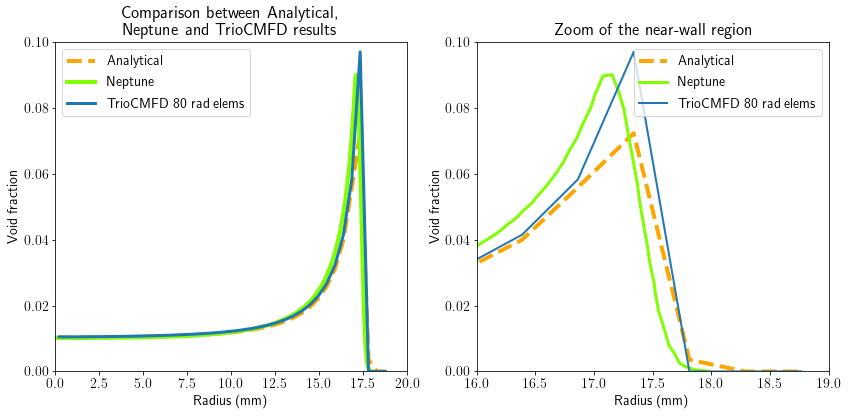

In [9]:
# Afficher tous les résultats de simu

# Colonnes : Titre, alpha, d, U (contient U_l et U_g), u'l

neptune = pd.read_csv(f"src/Neptune_analytique.csv")
    
color_ana = "orange"
color_neptune = "chartreuse"
marker_ana= "-"
marker_conf =  { "VDF_ICE" : "-", "VDF_SETS" : "--", "PolyMAC_ICE" : "-" , "PolyMAC_SETS" : ":"}

plt.figure(figsize = (12,6))

plt.subplot(121)
plt.plot(r*1000, alp, "-", color = color_ana, linewidth = 4, label = "Analytical")
plt.plot(np.array(neptune["r"]), neptune["alpha"], "-", color = color_neptune, linewidth = 4, label = "Neptune")
plt.xlim(0,20)
plt.ylim(0,.1)
for s in dt_ev.keys():
    if (s != "VDF_SETS"):
        f = os.open(f"./build/{s}/PAR_jdd_{s}.perf", os.O_RDONLY)
        time_loc = str(float(os.read(f, 200).split()[3])/60)[:5]
        plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['alp'], marker_conf[s], linewidth = 3, label = f"TrioCMFD {s.replace('_',' ')} {nrad[s.split('_')[0]]} rad elems {time_loc}min calc", color = color_conf[s])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Void fraction")
plt.title("Comparison between Analytical, \n Neptune and TrioCMFD results")
    
plt.subplot(122)

plt.plot(r*1000, alp, "-", color = color_ana, linewidth = 4, label = "Analytical")
plt.plot(np.array(neptune["r"]), neptune["alpha"], "-", color = color_neptune, linewidth = 3, label = "Neptune")
plt.xlim(16,19)
plt.ylim(0,.1)
for s in dt_ev.keys():
    if (s != "VDF_SETS"):
        plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['alp'], marker_conf[s], linewidth = 3, label = f"TrioCMFD {s.replace('_',' ')} {nrad[s.split('_')[0]]} rad elems", color = color_conf[s])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Void fraction")
plt.title("Zoom of the near-wall region")

plt.tight_layout()

plt.savefig("Resultats_tube_analytique.pdf")


In [ ]:
# Afficher tous les résultats de simu

# Colonnes : Titre, alpha, d, U (contient U_l et U_g), u'l

neptune = pd.read_csv(f"src/Neptune_analytique.csv")
    
color_ana = "orange"
color_neptune = "chartreuse"
marker_ana= "-"
marker_conf =  { "VDF_ICE" : "-", "VDF_SETS" : "--", "PolyMAC_ICE" : "-" , "PolyMAC_SETS" : ":"}

plt.figure(figsize = (12,6))

plt.subplot(121)
plt.xlim(0,20)
plt.ylim(0,1.2)
for s in dt_ev.keys():
    if (s != "VDF_SETS"):
        plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['vzl'], marker_conf[s], linewidth = 3, label = f"TrioCMFD {s.replace('_',' ')} {nrad[s.split('_')[0]]} rad elems", color = color_conf[s])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Liquid velocity")
plt.title("Comparison between Analytical, \n Neptune and TrioCMFD results")
    
plt.subplot(122)
plt.xlim(0,20)
plt.ylim(0,1.2)
for s in dt_ev.keys():
    if (s != "VDF_SETS"):
        plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['vzg'], marker_conf[s], linewidth = 3, label = f"TrioCMFD {s.replace('_',' ')} {nrad[s.split('_')[0]]} rad elems", color = color_conf[s])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Gas velocity")
plt.title("Zoom of the near-wall region")

plt.tight_layout()

plt.savefig("Velocities.pdf")
